## Loading Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, precision_score, recall_score, precision_recall_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
np.set_printoptions(threshold=np.inf)
pd.options.display.max_rows = 300
pd.options.display.max_columns = 300
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
##Block to define common function used through out

# create plotting functions
def data_type(variable):
    if variable.dtype == np.int64 or variable.dtype == np.float64:
        return 'numerical'
    elif variable.dtype == 'category':
        return 'categorical'
    
def univariate(variable, stats=True):
    
    if data_type(variable) == 'numerical':
        sns.distplot(variable)
        if stats == True:
            print(variable.describe())
    
    elif data_type(variable) == 'categorical':
        sns.countplot(variable)
        if stats == True:
            print(variable.value_counts())
            
    else:
        print("Invalid variable passed: either pass a numeric variable or a categorical vairable.")
        
def bivariate(var1, var2):
    if data_type(var1) == 'numerical' and data_type(var2) == 'numerical':
        sns.regplot(var1, var2)
    elif (data_type(var1) == 'categorical' and data_type(var2) == 'numerical') or (data_type(var1) == 'numerical' and data_type(var2) == 'categorical'):        
        sns.boxplot(var1, var2)


        
# function to generate plots related to Categorical Variables
def categorical_plot(col,x,y):
    plt.figure(figsize = (x,y))
    plt.subplot(1,2,1)
    sns.barplot(col,'cnt',data=df)
    #plt.subplot(1,2,2)
   # sns.barplot(col,'cnt',data=df, hue='yr',palette='Paired')
    #plt.legend(labels=['2018', '2019'])
    return

# function to calculate VIF
def calulateVIF(X_train_new):
    vif = pd.DataFrame()
    X = X_train_new
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif
        
# function to getStats model
def getStatModel(X_train_rfe,ytrain):
    X_train_rfe = sm.add_constant(X_train_rfe)
    lm = sm.OLS(ytrain,X_train_rfe).fit()   # Running the linear model
    return lm

# function to getStats model summary
def getStatModelSummary(X_train_rfe,ytrain):
    lm = getStatModel(X_train_rfe,ytrain)
    return lm.summary()

# Method to get null count

def getnullcount(dataframe):
    return dataframe.isnull().sum()

def getnullgreaterthanpercentage(dataframe,perct):
    null_count=round(100*(getnullcount(dataframe)/len(dataframe.index)),2)
    null_count=null_count[null_count>=perct]
    return null_count
    
# Method to get Meta-Data about any dataframe passed 
def retrievemetadata(dataframe) :
    metadata_matrix = pd.DataFrame({
                    'Datatype' : dataframe.dtypes, # data types of columns
                    'Total_Element': dataframe.count(), # total elements in columns
                    'Null_Count': dataframe.isnull().sum(), # total null values in columns
                    'Null_Percentage': dataframe.isnull().sum()/len(dataframe) * 100 # percentage of null values,
                       })
    return metadata_matrix

## Loading Data

In [3]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv("test.csv")

## Missing Values
Before we go on to build the model, we must look for missing values within the dataset as treating the missing values is a necessary step before we fit a logistic regression model on the dataset.

In [4]:
import sys
np.set_printoptions(threshold=np.inf, linewidth=200,edgeitems=50)
np.set_printoptions(threshold=sys.maxsize)
print(pd.isnull(df).sum())


id                              0
circle_id                       0
loc_og_t2o_mou                702
std_og_t2o_mou                702
loc_ic_t2o_mou                702
last_date_of_month_6            0
last_date_of_month_7          399
last_date_of_month_8          733
arpu_6                          0
arpu_7                          0
arpu_8                          0
onnet_mou_6                  2768
onnet_mou_7                  2687
onnet_mou_8                  3703
offnet_mou_6                 2768
offnet_mou_7                 2687
offnet_mou_8                 3703
roam_ic_mou_6                2768
roam_ic_mou_7                2687
roam_ic_mou_8                3703
roam_og_mou_6                2768
roam_og_mou_7                2687
roam_og_mou_8                3703
loc_og_t2t_mou_6             2768
loc_og_t2t_mou_7             2687
loc_og_t2t_mou_8             3703
loc_og_t2m_mou_6             2768
loc_og_t2m_mou_7             2687
loc_og_t2m_mou_8             3703
loc_og_t2f_mou

In [5]:
df.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000

In [6]:
#Checking the shape of the dataframe 
df.shape

(69999, 172)

In [7]:
# How many types of each data type column exists
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB
None


## filter customers that provide high value

#### Since number of rows are significantly high let's remove the rows by only concentrating on high value customers
High-value customers are who have recharged > 70th percentile of the average recharge amount in the first two months (the good phase).
### calculate total data recharge amount

In [8]:
# calc the total data recharge amount for June and July
df['total_data_rech_amt_6'] = df['av_rech_amt_data_6'] * df['total_rech_data_6']
df['total_data_rech_amt_7'] = df['av_rech_amt_data_7'] * df['total_rech_data_7']
df['total_data_rech_amt_8'] = df['av_rech_amt_data_8'] * df['total_rech_data_8']

# Drop the columns we have used already
df.drop(['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
              'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8'], axis=1, inplace=True)

In [9]:
# calc the total data recharge amount for June and July
df_test['total_data_rech_amt_6'] = df_test['av_rech_amt_data_6'] * df_test['total_rech_data_6']
df_test['total_data_rech_amt_7'] = df_test['av_rech_amt_data_7'] * df_test['total_rech_data_7']
df_test['total_data_rech_amt_8'] = df_test['av_rech_amt_data_8'] * df_test['total_rech_data_8']

# Drop the columns we have used already
df_test.drop(['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
              'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8'], axis=1, inplace=True)

In [10]:
# Find avg amt for good phase i.e June and July month
good_phase_average_rech_amt = ( df['total_rech_amt_6'].fillna(0) + df['total_rech_amt_7'].fillna(0) + 
                               df['total_data_rech_amt_6'].fillna(0) + df['total_data_rech_amt_7'].fillna(0) ) / 2

# 70 percentile of the good phase data
gd_phase_avg_rech_amt_70 = np.percentile(good_phase_average_rech_amt, 70.0)
print(f'70 Percentile of recharge amount is : {gd_phase_avg_rech_amt_70}')

#  high value customer we will keep and rest we will drop
df_HVCust = df[good_phase_average_rech_amt >= gd_phase_avg_rech_amt_70]

print(f'Shape of high value customer data: {df_HVCust.shape}')

70 Percentile of recharge amount is : 477.5
Shape of high value customer data: (21013, 169)


In [11]:
# calculate 2g and 3g data consumption
df_HVCust['total_internet_mb_8'] =  df_HVCust.vol_2g_mb_8 + df_HVCust.vol_3g_mb_8

## derive churn

In [12]:
# calculate total incoming and outgoing minutes of usage
df_HVCust['total_calls_mou_8'] = df_HVCust.total_ic_mou_8 + df_HVCust.total_og_mou_8

In [13]:
# create churn variable: those who have not used either calls or internet in the month of September are customers who have churned

# 0 - not churn, 1 - churn
df_HVCust['churn'] = df_HVCust.apply(lambda row: 1 if (row.total_calls_mou_8 == 0 and row.total_internet_mb_8 == 0) else 0, axis=1)

In [14]:
# delete derived variables
df_HVCust = df_HVCust.drop(['total_calls_mou_8', 'total_internet_mb_8'], axis=1)

In [15]:
# change data type to category
df_HVCust.churn = df_HVCust.churn.astype("category")

# print churn ratio
print("Churn Ratio:")
print(df_HVCust.churn.value_counts()*100/df_HVCust.shape[0])

Churn Ratio:
0    94.669966
1     5.330034
Name: churn, dtype: float64


In [16]:
#let's check the Columns with high missing percentage >=30% (30%  value I came to after looking up  null percentage)
null_count=getnullgreaterthanpercentage(df,30)
print(null_count)

date_of_last_rech_data_6    74.90
date_of_last_rech_data_7    74.48
date_of_last_rech_data_8    73.69
max_rech_data_6             74.90
max_rech_data_7             74.48
max_rech_data_8             73.69
count_rech_2g_6             74.90
count_rech_2g_7             74.48
count_rech_2g_8             73.69
count_rech_3g_6             74.90
count_rech_3g_7             74.48
count_rech_3g_8             73.69
arpu_3g_6                   74.90
arpu_3g_7                   74.48
arpu_3g_8                   73.69
arpu_2g_6                   74.90
arpu_2g_7                   74.48
arpu_2g_8                   73.69
night_pck_user_6            74.90
night_pck_user_7            74.48
night_pck_user_8            73.69
fb_user_6                   74.90
fb_user_7                   74.48
fb_user_8                   73.69
total_data_rech_amt_6       74.90
total_data_rech_amt_7       74.48
total_data_rech_amt_8       73.69
dtype: float64


In [17]:
df_HVCust.shape

(21013, 170)

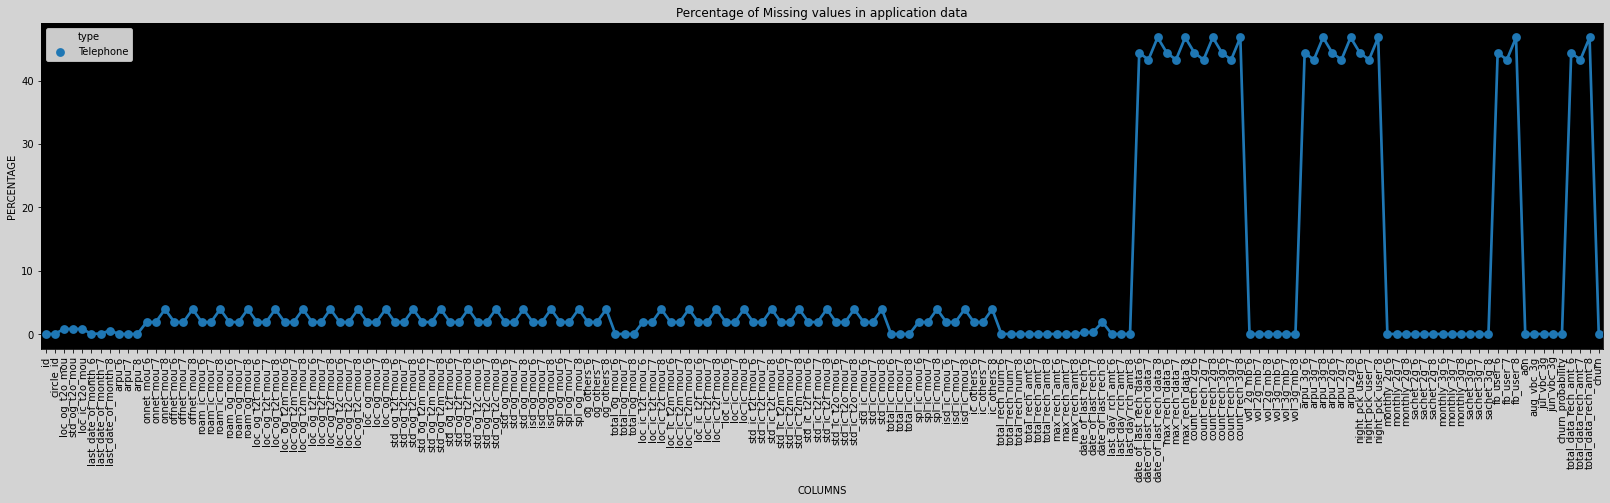

In [18]:
#Let's view the Null percentages in graph so that things become more clear

fig = plt.figure(figsize=(28,6))

miss_appdata = pd.DataFrame((df_HVCust.isnull().sum())*100/df_HVCust.shape[0]).reset_index()
miss_appdata["type"] = "Telephone"


ax = sns.pointplot("index",0,data=miss_appdata,hue="type")
plt.xticks(rotation =90,fontsize =10)
plt.title("Percentage of Missing values in application data")
plt.ylabel("PERCENTAGE")
plt.xlabel("COLUMNS")
ax.set_facecolor("k")
fig.set_facecolor("lightgrey")

In [19]:
#let's check the Columns with high missing percentage >=70% (70%  value I came to after looking up  null percentage)
null_count=getnullgreaterthanpercentage(df_HVCust,70)
print(null_count)

Series([], dtype: float64)


In [20]:
## Drop columns having > 70 % of null values
df_HVCust.drop(null_count.index, axis=1, inplace=True)

In [21]:
## Drop columns having > 70 % of null values
df_test.drop(null_count.index, axis=1, inplace=True)

In [22]:
df_HVCust.shape

(21013, 170)

In [23]:
df_test.shape

(30000, 168)

## Null Values treatment

In [24]:
print(df.date_of_last_rech_data_6.unique())


[nan '6/25/2014' '6/20/2014' '6/29/2014' '6/16/2014' '6/19/2014' '6/17/2014' '6/26/2014' '6/8/2014' '6/27/2014' '6/22/2014' '6/28/2014' '6/1/2014' '6/30/2014' '6/23/2014' '6/18/2014' '6/10/2014'
 '6/6/2014' '6/14/2014' '6/13/2014' '6/12/2014' '6/21/2014' '6/11/2014' '6/4/2014' '6/15/2014' '6/2/2014' '6/9/2014' '6/24/2014' '6/3/2014' '6/7/2014' '6/5/2014']


In [25]:

# impute numerical variables with '0' ,as these are dipctiong null values (i.e. customer has not used it)
null_with_meaning = ["max_rech_data_6", "max_rech_data_7", "max_rech_data_8", "count_rech_2g_6", "count_rech_2g_7", "count_rech_2g_8", "count_rech_3g_6", "count_rech_2g_7", "count_rech_2g_8", "count_rech_3g_6", "count_rech_3g_7","count_rech_3g_8","arpu_3g_6","arpu_3g_7","arpu_3g_8","arpu_2g_6","arpu_2g_7","arpu_2g_8","night_pck_user_6","night_pck_user_7","night_pck_user_8","fb_user_6","fb_user_7","fb_user_8"]
for i in null_with_meaning:
    df_HVCust[i].fillna("0", inplace=True)

In [26]:

# impute numerical variables with '0' ,as these are dipctiong null values (i.e. customer has not used it)
null_with_meaning = ["max_rech_data_6", "max_rech_data_7", "max_rech_data_8", "count_rech_2g_6", "count_rech_2g_7", "count_rech_2g_8", "count_rech_3g_6", "count_rech_2g_7", "count_rech_2g_8", "count_rech_3g_6", "count_rech_3g_7","count_rech_3g_8","arpu_3g_6","arpu_3g_7","arpu_3g_8","arpu_2g_6","arpu_2g_7","arpu_2g_8","night_pck_user_6","night_pck_user_7","night_pck_user_8","fb_user_6","fb_user_7","fb_user_8"]
for i in null_with_meaning:
    df_test[i].fillna("0", inplace=True)

In [27]:
#let's check the Columns with high missing percentage >=30% (30%  value I came to after looking up  null percentage)
null_count=getnullgreaterthanpercentage(df_HVCust,1)
print(null_count)
print(null_count.index)

onnet_mou_6                  1.89
onnet_mou_7                  1.87
onnet_mou_8                  3.91
offnet_mou_6                 1.89
offnet_mou_7                 1.87
offnet_mou_8                 3.91
roam_ic_mou_6                1.89
roam_ic_mou_7                1.87
roam_ic_mou_8                3.91
roam_og_mou_6                1.89
roam_og_mou_7                1.87
roam_og_mou_8                3.91
loc_og_t2t_mou_6             1.89
loc_og_t2t_mou_7             1.87
loc_og_t2t_mou_8             3.91
loc_og_t2m_mou_6             1.89
loc_og_t2m_mou_7             1.87
loc_og_t2m_mou_8             3.91
loc_og_t2f_mou_6             1.89
loc_og_t2f_mou_7             1.87
loc_og_t2f_mou_8             3.91
loc_og_t2c_mou_6             1.89
loc_og_t2c_mou_7             1.87
loc_og_t2c_mou_8             3.91
loc_og_mou_6                 1.89
loc_og_mou_7                 1.87
loc_og_mou_8                 3.91
std_og_t2t_mou_6             1.89
std_og_t2t_mou_7             1.87
std_og_t2t_mou

In [28]:
## Checking different values to find out what to impute
print(df.loc_ic_t2o_mou.unique())
print(df.ic_others_7.unique())
print(df.ic_others_8.unique())
print(df['onnet_mou_6'].value_counts())
print(df['offnet_mou_7'].value_counts())
print(df['isd_ic_mou_8'].value_counts())
print(df['ic_others_6'].value_counts())
print(df['roam_ic_mou_6'].value_counts())
print(df['roam_ic_mou_6'].value_counts())

[ 0. nan]
[6.90000e-01 0.00000e+00 1.90000e-01 1.75300e+01 4.60000e-01 2.00000e-01 1.50000e-01         nan 1.29400e+01 2.01000e+00 2.50000e-01 9.80000e-01 1.58000e+00 1.56100e+01 1.83000e+00 1.60000e-01
 1.80000e-01 4.10000e-01 1.55000e+00 1.49100e+01 8.30000e-01 4.50000e-01 6.00000e-02 2.80000e-01 1.59800e+01 6.30000e-01 7.00000e-01 6.00000e-01 7.36000e+00 2.40000e-01 2.69000e+00 9.68000e+00
 5.00000e-01 1.26000e+00 2.84000e+00 1.63000e+00 3.80000e-01 2.10000e-01 1.86000e+00 8.50000e-01 5.80000e-01 1.30000e-01 7.83000e+00 3.00000e-02 4.78000e+00 3.60000e-01 5.60000e-01 6.26000e+00
 1.21000e+00 1.90000e+00 4.30000e-01 1.65300e+01 9.64000e+00 4.00000e-01 6.14000e+00 1.46000e+00 8.60000e-01 4.80000e-01 4.28000e+00 2.30000e-01 3.30000e-01 2.04300e+01 3.00000e-01 2.15000e+00
 2.58000e+00 1.91000e+00 5.30000e-01 1.20500e+01 2.70000e+00 1.40000e+00 8.80000e-01 2.36000e+00 1.10000e-01 3.50000e-01 7.99000e+01 8.00000e-01 2.88000e+00 1.66000e+00 6.13000e+00 4.25100e+01
 1.37500e+01 2.90000e-01 

[0.00000e+00 2.50000e-01 2.40000e-01 4.05000e+00 5.50000e-01 4.00000e-01         nan 7.40000e-01 8.00000e-02 6.30000e-01 1.10000e+00 6.00000e-02 2.80000e-01 1.38000e+00 4.80000e-01 1.60000e-01
 1.13000e+00 5.00000e-02 1.78000e+00 5.30000e-01 1.50000e-01 1.16000e+00 2.00000e-01 3.50300e+01 1.91000e+00 1.80000e-01 1.76000e+00 5.27900e+01 6.60000e-01 1.49000e+00 1.30000e-01 3.80000e-01
 2.30000e-01 2.10000e-01 2.26300e+01 6.90000e-01 4.50000e-01 1.10000e-01 3.10000e-01 3.38000e+00 1.00000e-02 7.30000e-01 1.00000e-01 2.18000e+00 1.44000e+00 9.10000e-01 3.68000e+00 3.50000e-01
 1.53100e+01 4.10000e-01 7.00000e-01 1.81000e+00 9.40000e-01 2.55000e+00 6.36600e+01 5.10000e-01 1.35800e+01 1.29000e+00 1.93000e+00 4.61000e+00 2.30300e+01 1.90000e-01 1.68000e+00 1.53300e+01
 8.30000e-01 2.69000e+00 6.40000e-01 1.70000e+00 9.60000e-01 4.30000e-01 5.60000e-01 5.00000e-01 3.30000e-01 1.59300e+01 2.04000e+00 3.00000e-01 3.76300e+01 2.46000e+00 1.36000e+00 6.34000e+00
 1.46000e+00 5.26000e+00 3.45300e+0

In [29]:
#Imputing numerical values with mediam values for below
df_HVCust["ic_others_7"].fillna(df_HVCust["ic_others_7"].median(), inplace=True)
df_HVCust["ic_others_8"].fillna(df_HVCust["ic_others_8"].median(), inplace=True)
df_HVCust["ic_others_6"].fillna(df_HVCust["ic_others_6"].median(), inplace=True)


In [30]:
#Imputing numerical values with mediam values for below
df_test["ic_others_7"].fillna(df_test["ic_others_7"].median(), inplace=True)
df_test["ic_others_8"].fillna(df_test["ic_others_8"].median(), inplace=True)
df_test["ic_others_6"].fillna(df_test["ic_others_6"].median(), inplace=True)

In [31]:
# impute numerical variables with '0' ,as these are dipctiong null values (i.e. customer has not used it)
null_with_meaning = null_count.index
for i in null_with_meaning:
    df_HVCust[i].fillna("0", inplace=True)

In [32]:
# impute numerical variables with '0' ,as these are dipctiong null values (i.e. customer has not used it)
null_with_meaning = null_count.index
for i in null_with_meaning:
    df_test[i].fillna("0", inplace=True)

In [33]:
#let's check the Columns with high missing percentage >=30% (30%  value I came to after looking up  null percentage)
null_count=getnullgreaterthanpercentage(df_HVCust,1)
print(null_count)
print(null_count.index)

Series([], dtype: float64)
Index([], dtype='object')


In [34]:
df_HVCust.shape

(21013, 170)

In [35]:
df_test.shape

(30000, 168)

In [36]:
# Check columns for only 1 unique value
drop_col_sngl_val = []

for col in df_HVCust.columns:
    if df_HVCust[f'{col}'].nunique() == 1:
        drop_col_sngl_val.append(col)

drop_col_sngl_val

# Drop single value columns
df_HVCust.drop(drop_col_sngl_val, axis=1, inplace=True)
df_HVCust.shape

(21013, 163)

In [37]:
# Check columns for only 1 unique value
drop_col_sngl_val = []

for col in df_test.columns:
    if df_test[f'{col}'].nunique() == 1:
        drop_col_sngl_val.append(col)

drop_col_sngl_val

# Drop single value columns
df_test.drop(drop_col_sngl_val, axis=1, inplace=True)
df_test.shape

(30000, 161)

## Driving new features

In [38]:
df_HVCust.columns.tolist()

['id',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8

In [39]:

# Create new column
df_HVCust['gd_ph_arpu'] = ( df_HVCust['arpu_6'] + df_HVCust['arpu_7'] ) / 2

# Drop redundant column
df_HVCust.drop(['arpu_6', 'arpu_7', 'arpu_8'], axis=1, inplace=True)


df_HVCust.head()

,id,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,churn,gd_ph_arpu
4,4,21.28,4.83,6.13,56.99,38.11,9.63,53.64,0.0,0.0,15.73,0.0,0.0,10.16,4.83,6.13,36.74,19.88,4.61,11.99,1.23,5.01,0.0,9.85,0.0,58.91,25.94,15.76,0.0,0.0,0.0,4.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.35,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,63.26,42.94,15.76,5.44,1.39,2.66,10.58,4.33,19.49,5.51,3.63,6.14,21.54,9.36,28.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.54,9.36,28.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,13,10,8,290,136,122,50,41,30,6/25/2014,7/26/2014,8/30/2014,25,10,30,6/25/2014,7/23/2014,8/20/2014,25.0,41.0,25.0,7.0,6.0,6.0,0.0,1.0,0.0,390.80,308.89,213.47,0.0,0.00,0.00,0.0,35.0,0.0,0.0,35.12,0.0,0.0,0.0,0.0,0,0,0,7,6,6,0,0,0,0,1,0,1.0,1.0,1.0,647,0.0,0.00,0.00,0,1225.0,1337.0,852.0,0,184.4495
15,15,10.43,24.99,194.43,317.11,341.79,197.09,0.0,0.0,0.0,0.0,0.0,0.0,10.43,24.99,194.43,313.76,330.88,185.88,3.26,10.91,4.94,0.0,0.0,0.0,327.46,366.79,385.26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.26,0.0,0.0,0.0,0.0,0.0,6.26,0.0,0.0,0.0,0.08,0.0,0.0,0.1,0.0,0.0,327.64,366.79,391.53,13.86,20.18,335.43,219.31,754.24,285.63,0.0,1.93,8.88,233.18,776.36,629.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.03,0.0,0.0,0.0,0.0,0.0,1.03,0.0,233.18,777.39,629.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,5,3,4,654,400,652,250,250,250,6/27/2014,7/25/2014,8/30/2014,0,150,250,6/16/2014,0,8/2/2014,154.0,0,154.0,1.0,0,1.0,0.0,0,0.0,260.42,0.00,354.35,0.0,0.00,0.00,0.0,0,0.0,164.75,0,28.8,0.0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,1.0,0,1.0,602,0.0,0.00,0.00,0,154.0,0,154.0,0,478.9215
23,23,859.53,372.71,0.89,293.46,450.11,386.91,0.0,0.0,0.0,0.0,0.0,0.0,859.53,372.71,0.89,79.79,424.63,378.01,11.58,25.43,8.88,0.0,0

In [40]:
# Create new column
df_test['gd_ph_arpu'] = ( df_test['arpu_6'] + df_test['arpu_7'] ) / 2

# Drop redundant column
df_test.drop(['arpu_6', 'arpu_7', 'arpu_8'], axis=1, inplace=True)


df_test.head()

,id,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,gd_ph_arpu
0,69999,31.78,20.23,23.11,60.16,32.16,34.83,0.0,0.0,0.0,0.0,0.0,0.0,24.88,20.23,21.06,18.13,10.89,8.36,0.0,13.58,0.0,0.0,0.0,0.03,43.01,44.71,29.43,6.9,0.0,2.05,42.03,7.68,26.43,0.0,0.0,0.0,0.0,0.0,0.0,48.93,7.68,28.48,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.0,0.0,40.81,42.16,31.51,0.0,0.0,0.0,0.36,1.04,4.34,0.0,0.0,0.0,0.0,0.0,0.0,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.0,0.0,0.0,0.0,0.0,0.00,5,5,4,103,90,60,50,30,30,6/21/2014,7/26/2014,8/24/2014,30,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1692,0.00,0.00,0.00,0,0,0,78.6060
1,70000,75.51,41.21,19.84,474.34,621.84,394.94,0.0,0.0,0.0,0.0,0.0,0.0,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.0,0.0,0.0,0.0,0.0,549.86,639.29,397.11,0.0,0.0,0.0,0.0,23.76,17.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.76,17.68,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.0,0.0,181.69,149.24,187.43,0.0,0.0,0.0,0.0,12.51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.51,0.0,296.33,339.64,281.66,0.0,0.0,0.0,114.63,177.88,94.23,0.0,0.0,0.00,5,4,5,500,500,500,250,250,250,6/19/2014,7/16/2014,8/24/2014,250,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2533,0.00,0.00,0.00,0,0,0,464.8680
2,70001,7.54,7.86,8.4,16.98,45.81,45.04,22.81,103.38,26.08,24.53,53.68,54.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [41]:
# How many types of each data type column exists
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 169 entries, id to total_data_rech_amt_8
dtypes: float64(132), int64(28), object(9)
memory usage: 90.3+ MB


## EDA

In [42]:
df.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417

count    69999.000000
mean       283.134365
std        334.213918
min      -2258.709000
25%         93.581000
50%        197.484000
75%        370.791000
max      27731.088000
Name: arpu_6, dtype: float64


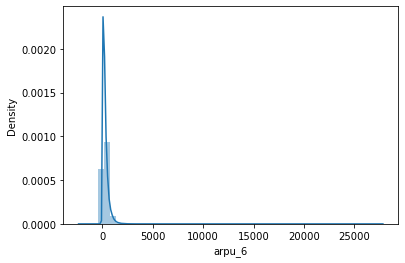

In [43]:
univariate(df.arpu_6)

count    67312.000000
mean       133.894438
std        311.277193
min          0.000000
25%          6.675000
50%         32.280000
75%        115.837500
max       8157.780000
Name: onnet_mou_7, dtype: float64


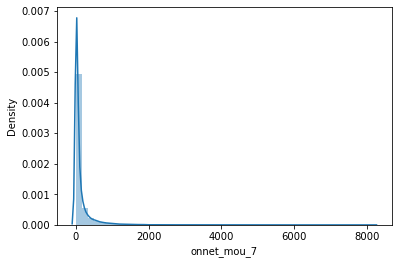

In [44]:
univariate(df.onnet_mou_7)

count    66296.000000
mean       196.543577
std        324.089234
min          0.000000
25%         31.575000
50%         91.800000
75%        229.345000
max      14007.340000
Name: offnet_mou_8, dtype: float64


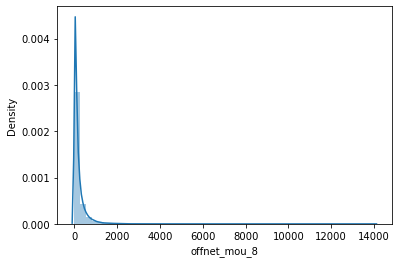

In [45]:
univariate(df.offnet_mou_8)

count    69297.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: std_og_t2o_mou, dtype: float64


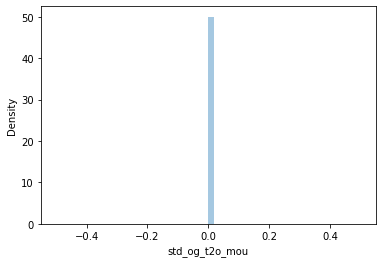

In [46]:
univariate(df.std_og_t2o_mou)

## Bivariate EDA

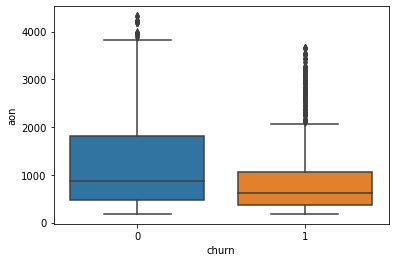

In [47]:
bivariate(df_HVCust.churn, df_HVCust.aon)

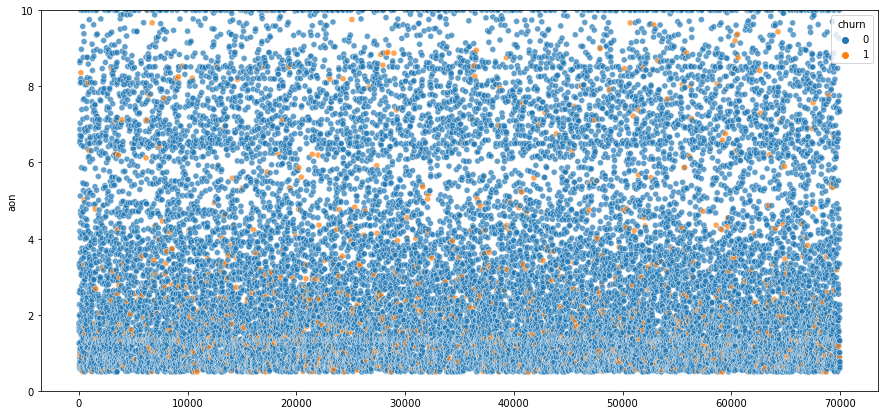

In [48]:
# Check churn based on tenure

plt.figure(figsize=(15,7))
sns.scatterplot(y=df['aon'] / 365, x=df.index, hue=df_HVCust.churn, alpha=0.7)
plt.ylim(0,10)
plt.show()

## Observation
We can see customers whose tenure is < 3 years have churned

## Standardize values for further analysis

In [49]:
# columns to be scaled
num_vars = df_HVCust.select_dtypes(include=['int64','int32','float64','float32']).columns
num_vars = num_vars.str.replace(' ', '')

In [50]:
num_vars = num_vars.drop("churn_probability")

In [51]:
X_train = df_HVCust.copy()

In [52]:
y_train = df_HVCust["churn_probability"]

In [53]:
#X_train = df_HVCust.pop("churn_probability")

In [54]:
#num_vars
#X_train = df_HVCust[num_vars.tolist()]


In [55]:
X_train.reset_index()

,index,id,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,churn,gd_ph_arpu
0,4,4,21.28,4.83,6.13,56.99,38.11,9.63,53.64,0.0,0.0,15.73,0.0,0.0,10.16,4.83,6.13,36.74,19.88,4.61,11.99,1.23,5.01,0.0,9.85,0.0,58.91,25.94,15.76,0.0,0.0,0.0,4.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.35,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,63.26,42.94,15.76,5.44,1.39,2.66,10.58,4.33,19.49,5.51,3.63,6.14,21.54,9.36,28.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.54,9.36,28.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,13,10,8,290,136,122,50,41,30,6/25/2014,7/26/2014,8/30/2014,25,10,30,6/25/2014,7/23/2014,8/20/2014,25.0,41.0,25.0,7.0,6.0,6.0,0.0,1.0,0.0,390.80,308.89,213.47,0.00,0.00,0.00,0.0,35.0,0.0,0.0,35.12,0.0,0.0,0.0,0.0,0,0,0,7,6,6,0,0,0,0,1,0,1.0,1.0,1.0,647,0.00,0.00,0.00,0,1225.0,1337.0,852.0,0,184.4495
1,15,15,10.43,24.99,194.43,317.11,341.79,197.09,0.0,0.0,0.0,0.0,0.0,0.0,10.43,24.99,194.43,313.76,330.88,185.88,3.26,10.91,4.94,0.0,0.0,0.0,327.46,366.79,385.26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.26,0.0,0.0,0.0,0.0,0.0,6.26,0.0,0.0,0.0,0.08,0.0,0.0,0.1,0.0,0.0,327.64,366.79,391.53,13.86,20.18,335.43,219.31,754.24,285.63,0.0,1.93,8.88,233.18,776.36,629.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.03,0.0,0.0,0.0,0.0,0.0,1.03,0.0,233.18,777.39,629.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,5,3,4,654,400,652,250,250,250,6/27/2014,7/25/2014,8/30/2014,0,150,250,6/16/2014,0,8/2/2014,154.0,0,154.0,1.0,0,1.0,0.0,0,0.0,260.42,0.00,354.35,0.00,0.00,0.00,0.0,0,0.0,164.75,0,28.8,0.0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,1.0,0,1.0,602,0.00,0.00,0.00,0,154.0,0,154.0,0,478.9215
2,23,23,859.53,372.71,0.89,293.46,450.11,386.91,0.0,0.0,0.0,0.0,0.0,0.0,859.53,372.71,0.89,79.79,424.63,378.01,11.58,

In [56]:
#Scaling using MinMax
from sklearn.preprocessing import StandardScaler,MinMaxScaler
#scaler = StandardScaler()
scaler=MinMaxScaler()
X_train = scaler.fit_transform(df_HVCust[num_vars])
#y_train = pd.DataFrame(X_train,columns=num_vars)

In [57]:
X_test_org = scaler.transform(df_test[num_vars])

In [58]:
X_train = pd.DataFrame(X_train)
X_test_org = pd.DataFrame(X_test_org)

In [59]:
# Get the dummy variables for the feature weathersit' and store it in a new variable - 'status'
#df=pd.get_dummies(df,drop_first=True)
df_HVCust.head()

,id,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,churn,gd_ph_arpu
4,4,21.28,4.83,6.13,56.99,38.11,9.63,53.64,0.0,0.0,15.73,0.0,0.0,10.16,4.83,6.13,36.74,19.88,4.61,11.99,1.23,5.01,0.0,9.85,0.0,58.91,25.94,15.76,0.0,0.0,0.0,4.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.35,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,63.26,42.94,15.76,5.44,1.39,2.66,10.58,4.33,19.49,5.51,3.63,6.14,21.54,9.36,28.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.54,9.36,28.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,13,10,8,290,136,122,50,41,30,6/25/2014,7/26/2014,8/30/2014,25,10,30,6/25/2014,7/23/2014,8/20/2014,25.0,41.0,25.0,7.0,6.0,6.0,0.0,1.0,0.0,390.80,308.89,213.47,0.0,0.00,0.00,0.0,35.0,0.0,0.0,35.12,0.0,0.0,0.0,0.0,0,0,0,7,6,6,0,0,0,0,1,0,1.0,1.0,1.0,647,0.0,0.00,0.00,0,1225.0,1337.0,852.0,0,184.4495
15,15,10.43,24.99,194.43,317.11,341.79,197.09,0.0,0.0,0.0,0.0,0.0,0.0,10.43,24.99,194.43,313.76,330.88,185.88,3.26,10.91,4.94,0.0,0.0,0.0,327.46,366.79,385.26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.26,0.0,0.0,0.0,0.0,0.0,6.26,0.0,0.0,0.0,0.08,0.0,0.0,0.1,0.0,0.0,327.64,366.79,391.53,13.86,20.18,335.43,219.31,754.24,285.63,0.0,1.93,8.88,233.18,776.36,629.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.03,0.0,0.0,0.0,0.0,0.0,1.03,0.0,233.18,777.39,629.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,5,3,4,654,400,652,250,250,250,6/27/2014,7/25/2014,8/30/2014,0,150,250,6/16/2014,0,8/2/2014,154.0,0,154.0,1.0,0,1.0,0.0,0,0.0,260.42,0.00,354.35,0.0,0.00,0.00,0.0,0,0.0,164.75,0,28.8,0.0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,1.0,0,1.0,602,0.0,0.00,0.00,0,154.0,0,154.0,0,478.9215
23,23,859.53,372.71,0.89,293.46,450.11,386.91,0.0,0.0,0.0,0.0,0.0,0.0,859.53,372.71,0.89,79.79,424.63,378.01,11.58,25.43,8.88,0.0,0

In [60]:
df_HVCust.shape

(21013, 161)

In [61]:
from sklearn.decomposition import PCA

pca = PCA(n_components=40,random_state=42)

#explained_variane = pca.explained_variance_ratio_

### Performing PCA

In [62]:
#?PCA

In [63]:
pca.fit(X_train)

PCA(n_components=40, random_state=42)

In [64]:
df_test_pca = pca.transform(X_test_org)

In [65]:
pca.components_

array([[ 9.99952838e-01, -8.45568919e-04, -2.24149024e-04,  3.17163537e-04,  2.02557682e-03,  2.81201107e-03,  3.09731437e-03,  2.00713138e-04,  1.57392555e-04,  2.95046817e-04, -4.13203831e-04,
        -5.96618700e-05, -9.42167606e-04,  1.04391072e-04,  3.53011195e-04,  4.44155176e-04,  1.50317040e-03,  2.12500347e-03,  2.55999634e-03,  2.73757404e-04,  1.45339864e-03,  9.09055894e-04,
         3.99683570e-04, -1.61645680e-03,  1.31756635e-04,  4.60470139e-04,  8.43599032e-04,  1.22723953e-03, -4.05801599e-03,  3.17498962e-04,  1.75796321e-03, -1.62668374e-03, -9.97388047e-04,
        -9.76071460e-04,  3.27835100e-03,  1.37181923e-03,  1.37414008e-03, -5.13914066e-05,  1.86358713e-05, -3.82364416e-04,  2.37340651e-03,  1.54330862e-03,  1.03632863e-03,  8.26975649e-04,
         2.26990263e-04],
       [-3.19356758e-03, -1.17323725e-02, -2.15652971e-02, -3.23549806e-03,  3.64666267e-02,  3.80297551e-02,  4.80432335e-02,  1.00373985e-03,  9.17856210e-04,  8.28553202e-04, -4.47773867e-02,

In [66]:
pca.explained_variance_ratio_

array([3.44675093e-01, 2.26080999e-01, 8.79914087e-02, 5.71779904e-02, 5.17140205e-02, 3.43552458e-02, 2.54315789e-02, 2.08279923e-02, 2.01507388e-02, 1.42234151e-02, 1.39534492e-02, 1.07299093e-02,
       1.03827032e-02, 8.59629550e-03, 7.88823910e-03, 7.41984277e-03, 6.42063686e-03, 5.75793744e-03, 5.34293088e-03, 3.98173134e-03, 3.55738917e-03, 3.44244748e-03, 2.98554779e-03, 2.80419298e-03,
       2.36953203e-03, 2.23943749e-03, 2.13737206e-03, 2.00296757e-03, 1.71244956e-03, 1.66491603e-03, 1.54026560e-03, 1.51728623e-03, 1.44274480e-03, 1.41109989e-03, 1.38925401e-03, 1.22212783e-03,
       1.17351765e-03, 1.04636823e-03, 4.08380356e-04, 3.23178620e-04])

In [67]:
## Dump components relations with features:
print(pd.DataFrame(pca.components_,columns=X_train.columns))

          0         1         2         3         4         5         6   \
0   0.999953 -0.000846 -0.000224  0.000317  0.002026  0.002812  0.003097   
1  -0.003194 -0.011732 -0.021565 -0.003235  0.036467  0.038030  0.048043   
2   0.000810 -0.193783 -0.287861 -0.141849 -0.012471 -0.018496 -0.016011   
3   0.001048  0.347577  0.544376  0.280242  0.097341  0.120495  0.140617   
4  -0.005431  0.127730  0.166884  0.076823  0.058410  0.067410  0.071993   
5  -0.004510 -0.040859  0.004020  0.043553  0.100849  0.128218  0.170000   
6  -0.003379 -0.087044 -0.157305 -0.049116  0.454147  0.504414  0.599900   
7  -0.001299  0.097149  0.234621  0.125063 -0.111070 -0.097869 -0.105650   
8   0.003250  0.099914  0.144496  0.067989 -0.033258 -0.043411 -0.059027   
9  -0.000203 -0.297103 -0.240513 -0.036400 -0.089417 -0.060076 -0.038039   
10 -0.001579 -0.105078 -0.094002 -0.003127 -0.056419 -0.049055 -0.029754   
11  0.000179  0.480195 -0.264576 -0.287650  0.149349 -0.024321 -0.131457   
12  0.000403

In [68]:
import matplotlib.pyplot as plt

<BarContainer object of 40 artists>

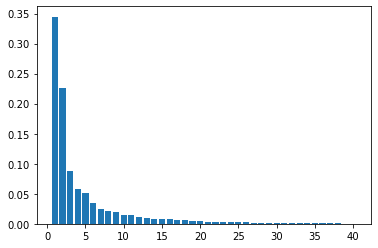

In [69]:
plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)

In [70]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

## Making the scree plot

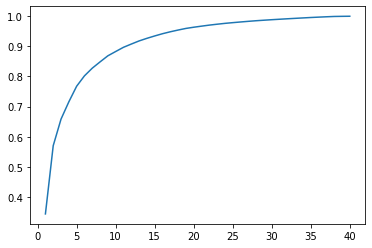

In [71]:
plt.plot(range(1,len(var_cumu)+1), var_cumu)

## Looks like 10 features are sufficient to explain 95% of variance 

In [72]:
pca = PCA(n_components=10,random_state=42)

In [73]:
newdata= pca.fit_transform(X_train)

In [74]:
#newdata_test= pca.transform(df_test)

In [75]:
newdata.shape

(21013, 10)

In [76]:
pca.components_

array([[ 9.99952838e-01, -8.45568942e-04, -2.24148993e-04,  3.17163510e-04,  2.02557684e-03,  2.81201108e-03,  3.09731434e-03,  2.00713139e-04,  1.57392556e-04,  2.95046817e-04, -4.13203829e-04,
        -5.96618881e-05, -9.42167588e-04,  1.04391071e-04,  3.53011197e-04,  4.44155168e-04,  1.50317043e-03,  2.12500352e-03,  2.55999631e-03,  2.73757404e-04,  1.45339860e-03,  9.09055839e-04,
         3.99683589e-04, -1.61645680e-03,  1.31756642e-04,  4.60470146e-04,  8.43599042e-04,  1.22723955e-03, -4.05801600e-03,  3.17498958e-04,  1.75796321e-03, -1.62668371e-03, -9.97388109e-04,
        -9.76071431e-04,  3.27835098e-03,  1.37181923e-03,  1.37414010e-03, -5.13914177e-05,  1.86358523e-05, -3.82364410e-04,  2.37340651e-03,  1.54330863e-03,  1.03632862e-03,  8.26975648e-04,
         2.26990262e-04],
       [-3.19356758e-03, -1.17323725e-02, -2.15652970e-02, -3.23549826e-03,  3.64666270e-02,  3.80297552e-02,  4.80432332e-02,  1.00373986e-03,  9.17856218e-04,  8.28553199e-04, -4.47773869e-02,

In [77]:
# Get the transformed dataset
newdata = pd.DataFrame(newdata)
#newdata_test = pd.DataFrame(newdata_test)

In [78]:
## Dump components relations with features:
print(pd.DataFrame(pca.components_,columns=X_train.columns))

         0         1         2         3         4         5         6   \
0  0.999953 -0.000846 -0.000224  0.000317  0.002026  0.002812  0.003097   
1 -0.003194 -0.011732 -0.021565 -0.003235  0.036467  0.038030  0.048043   
2  0.000810 -0.193783 -0.287861 -0.141849 -0.012471 -0.018496 -0.016011   
3  0.001048  0.347577  0.544376  0.280242  0.097341  0.120495  0.140617   
4 -0.005431  0.127730  0.166884  0.076823  0.058411  0.067411  0.071992   
5 -0.004510 -0.040861  0.004023  0.043549  0.100851  0.128220  0.169997   
6 -0.003379 -0.087036 -0.157312 -0.049110  0.454144  0.504411  0.599905   
7 -0.001300  0.097172  0.234583  0.125103 -0.111114 -0.097894 -0.105602   
8  0.003250  0.099887  0.144524  0.067969 -0.033199 -0.043389 -0.059086   
9 -0.000203 -0.297289 -0.240328 -0.036517 -0.089336 -0.059993 -0.038157   

         7         8         9         10        11        12        13  \
0  0.000201  0.000157  0.000295 -0.000413 -0.000060 -0.000942  0.000104   
1  0.001004  0.000918  0

<AxesSubplot:>

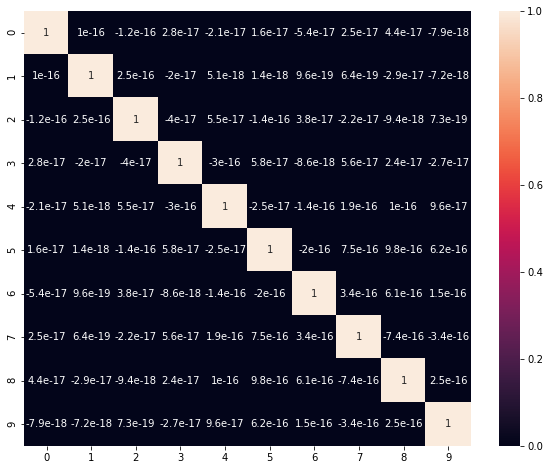

In [79]:
fig = plt.figure(figsize=(10, 8))
sns.heatmap(newdata.corr(), 
            annot=True)

## Observations
We cannot see any correlation between components. This is because PCA has transformed the set of correlated variables in the original dataset into a set of uncorrelated variables

## Model Building

## PCA and Logistic Regression

In [80]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.feature_selection import RFE

In [81]:
y_train = df_HVCust["churn_probability"]

In [82]:
X_train.shape

(21013, 45)

Train accuracy: 0.92
Test accuracy: 0.92
[[5773   24]
 [ 483   24]]

Test confusion_matrix


Text(33.0, 0.5, 'True')

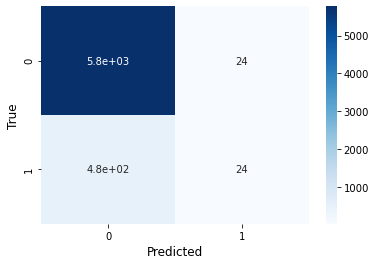

In [83]:
# Make train and test sets
from sklearn.model_selection import train_test_split
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_train, y_train, test_size=0.30, 
                                                            shuffle=True, random_state=2)

# Initialize the logistic regression model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=2500)

# Train the model
clf.fit(X_train_pca, y_train)

# Make predictions
y_pred = clf.predict(X_test_pca) # Predictions
y_true = y_test  # True values

# Measure accuracy
from sklearn.metrics import accuracy_score
import numpy as np
print("Train accuracy:", np.round(accuracy_score(y_train, 
                                                 clf.predict(X_train_pca)), 2))
print("Test accuracy:", np.round(accuracy_score(y_test,  clf.predict(X_test_pca)), 2))

# Make the confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, clf.predict(X_test_pca))
print(cf_matrix)
print("\nTest confusion_matrix")
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

In [84]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      5797
           1       0.50      0.05      0.09       507

    accuracy                           0.92      6304
   macro avg       0.71      0.52      0.52      6304
weighted avg       0.89      0.92      0.89      6304



In [85]:
# Train the model
# Make predictions
#y_pred = clf.predict(df_test) # Predictions
#y_true = y_train # True values

## Random Forest

In [86]:
fold = StratifiedKFold(n_splits = 3)

In [87]:

grid2 = [
    {   'n_estimators' : [250],
        'max_depth' : [ 7], 
        'max_features' : [ 15],
        'min_samples_split':[3, 4],
        'min_samples_leaf':[1,2],
        "class_weight":['balanced', {0:1,1:10}]
    }    
]

gscv2 = HalvingGridSearchCV(RandomForestClassifier(random_state = 100), grid2, cv = fold , scoring = 'accuracy', verbose = 1, n_jobs = -1)

In [88]:
gfit2 = gscv2.fit(X_train_pca, y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 4903
max_resources_: 14709
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 4903
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 3
n_resources: 14709
Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [89]:
print("score : {}".format(gfit2.best_score_))
gfit2.best_params_

score : 0.9257597389353457


{'class_weight': {0: 1, 1: 10},
 'max_depth': 7,
 'max_features': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 250}

In [90]:
rf_best = gfit2.best_estimator_

In [91]:
rf_best.feature_importances_

array([0.0053547 , 0.01227824, 0.01885494, 0.13529894, 0.01378882, 0.02034368, 0.2995993 , 0.00151003, 0.0019325 , 0.00294603, 0.00734314, 0.01269494, 0.01610731, 0.00870699, 0.01445545, 0.11007392,
       0.00550729, 0.00469218, 0.0412374 , 0.00317496, 0.00491816, 0.11232149, 0.00510956, 0.00508941, 0.04394822, 0.00501092, 0.00505569, 0.02589492, 0.0005537 , 0.00058826, 0.00124068, 0.00148013,
       0.00136682, 0.0045651 , 0.00077709, 0.00074553, 0.00059262, 0.00063137, 0.00129746, 0.00075231, 0.00966858, 0.00738076, 0.00346872, 0.00338516, 0.01825656])

In [92]:
y_pred2 = rf_best.predict(X_test_pca)

[[5453  344]
 [ 159  348]]

Test confusion_matrix


Text(33.0, 0.5, 'True')

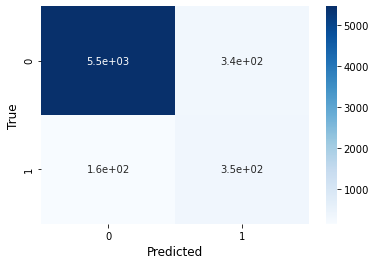

In [93]:
cf_matrix =confusion_matrix(y_test, y_pred2)
print(cf_matrix)
print("\nTest confusion_matrix")
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

In [94]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      5797
           1       0.50      0.69      0.58       507

    accuracy                           0.92      6304
   macro avg       0.74      0.81      0.77      6304
weighted avg       0.93      0.92      0.93      6304



In [95]:
precision_score(y_test, y_pred2)

0.5028901734104047

In [96]:
recall_score(y_test, y_pred2)

0.6863905325443787

## Top Features

In [97]:
rf_df = pd.DataFrame({'feature' : X_test_pca[col].columns, 'importance' : rf_best.feature_importances_})
rf_df = rf_df.sort_values(by = 'importance', ascending = False).head(20)
fig = plt.figure(figsize = (12, 9))
sns.barplot(data = rf_df, y = 'feature', x = 'importance')
plt.show()

KeyError: 'total_data_rech_amt_8'

### Test Data Set

In [ ]:
y_pred_test = rf_best.predict(X_test_org)

### 7. Creating submission file

In [ ]:
solution = pd.read_csv('solution.csv')
solution.head()

In [ ]:
print("Probabilities in Earlier file")
solution['churn_probability'].value_counts()

In [ ]:
solution['churn_probability'] = y_pred_test

In [ ]:
print("Probabilities after updating")
solution['churn_probability'].value_counts()

In [ ]:
submission = solution.to_csv('solution.csv', index=False)

In [ ]:
solution.head()